In [219]:
!pip install openpyxl

In [1]:
import pandas as pd

In [2]:
import re

In [307]:
data_zovut = pd.read_excel('VK_tebya_zovyt_vol2.xlsx', index_col=0)

In [308]:
data_kill = pd.read_excel('VK_killer_stories.xlsx', index_col=0)

In [309]:
data_msk = pd.read_excel('VK_pmmgo.xlsx', index_col=0)

## 1. Соединить данные в один датафрейм, присвоить уникальные обозначения

In [225]:
source_dict = {-72296316:'TZ', -55544604:'KS', -144260965:'MSK'}

In [226]:
def key_dialogue(data):
    abbr = source_dict[data['source_id'][0]]
    keys = [abbr+str(data['N_dialogue'][i]) for i in range(len(data))]
    data['N_dialogue'] = keys

In [227]:
key_dialogue(data_zovut)

In [228]:
key_dialogue(data_kill)

In [229]:
key_dialogue(data_msk)

In [416]:
VKdf = pd.concat([data_zovut, data_kill, data_msk], axis=0) 

In [231]:
VKdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599954 entries, 0 to 414552
Data columns (total 7 columns):
N_dialogue    599954 non-null object
post_id       599954 non-null int64
post_text     593898 non-null object
comment_id    599954 non-null int64
author_id     599954 non-null int64
text          574569 non-null object
source_id     599954 non-null int64
dtypes: int64(4), object(3)
memory usage: 36.6+ MB


In [232]:
# сохраним результат
VKdf.to_excel(f'VK_all_data.xlsx')

## 2. Очистить датафрейм от NaN и эмодзи

In [290]:
VKdf = pd.read_excel('VK_all_data.xlsx', index_col=0)

In [417]:
# Count missing values 
VKdf.isna().sum()

N_dialogue        0
post_id           0
post_text      6056
comment_id        0
author_id         0
text          25385
source_id         0
dtype: int64

In [418]:
VKdf = VKdf.dropna()

In [420]:
# from Stack Overflow

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
                                u"\U00000000-\U00000009"
                                u"\U0000000B-\U0000001F"
                                u"\U00000080-\U00000400"
                                u"\U00000402-\U0000040F"
                                u"\U00000450-\U00000450"
                                u"\U00000452-\U0010FFFF"
                                "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [421]:
clean_texts = [deEmojify(str(text)) for text in VKdf['text']]
VKdf['clean_text'] = clean_texts

Теперь в столбике clean_text могут быть пустые строки, которые не считываются как NaN

In [422]:
VKdf.drop(VKdf[VKdf['clean_text'] == ''].index, inplace = True)

In [423]:
def NaN_empty_answers(text):
    regrex_pattern = re.compile(pattern = '\[id[0-9]+\|[A-Za-zА-Яа-яЁё]+\], $')
    return regrex_pattern.sub(r'NaN',text)

In [424]:
NaN_empty_answers_texts = [NaN_empty_answers(text) for text in VKdf['clean_text']]

In [425]:
VKdf['clean_text'] = NaN_empty_answers_texts

In [426]:
VKdf.drop(VKdf[VKdf['clean_text'] == 'NaN'].index, inplace = True)

In [427]:
VKdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541072 entries, 0 to 414551
Data columns (total 8 columns):
N_dialogue    541072 non-null int64
post_id       541072 non-null int64
post_text     541072 non-null object
comment_id    541072 non-null int64
author_id     541072 non-null int64
text          541072 non-null object
source_id     541072 non-null int64
clean_text    541072 non-null object
dtypes: int64(5), object(3)
memory usage: 37.2+ MB


## 3. Токсичность текстов

This is the cointegrated/rubert-tiny model fine-tuned for classification of toxicity and inappropriateness for short informal Russian texts, such as comments in social networks.

ссылка - https://huggingface.co/cointegrated/rubert-tiny-toxicity

In [429]:
!pip install transformers sentencepiece --quiet
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [430]:
model_checkpoint = 'cointegrated/rubert-tiny-toxicity'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
if torch.cuda.is_available():
    model.cuda()

C:\Users\sara7\Anaconda3\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sara7\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [431]:
def text2toxicity(text, aggregate=True):
    """ Calculate toxicity of a text (if aggregate=True) or a vector of toxicity aspects (if aggregate=False)"""
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(model.device)
        proba = torch.sigmoid(model(**inputs).logits).cpu().numpy()
    if isinstance(text, str):
        proba = proba[0]
    if aggregate:
        return 1 - proba.T[0] * (1 - proba.T[-1])
    return proba

In [432]:
toxicity_rubert = [round(text2toxicity(text, aggregate=True), 3) for text in VKdf['clean_text']]

In [433]:
VKdf['toxicity_rubert'] = toxicity_rubert

In [ ]:
# сохраним результат
VKdf.to_excel(f'VK_all_data_toxicity.xlsx')

### Распределение данных по токсичности

In [4]:
VKdf = pd.read_excel('VK_all_data_toxicity.xlsx', index_col=0)

In [5]:
import seaborn as sns

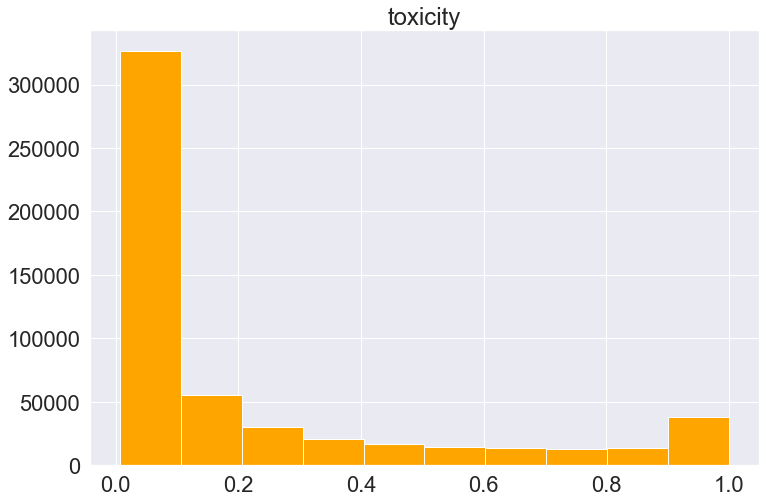

In [6]:
sns.set(font_scale=2, rc={'figure.figsize':(12,8)})

ax=VKdf['toxicity_rubert'].hist(color='orange').set_title('toxicity')

In [8]:
VKdf[VKdf['toxicity_rubert'] > 0.5]

,N_dialogue,post_id,post_text,comment_id,author_id,text,source_id,clean_text,toxicity_rubert
41,14,2404074,"мои потешные фотокарточки родом из детства, ко...",2404109,226612836,Словно припрятала барбарисок в подсобке на слу...,-72296316,Словно припрятала барбарисок в подсобке на слу...,0.834
68,37,2404074,"мои потешные фотокарточки родом из детства, ко...",2404275,39047740,Я по жизни голая грустная в тазике,-72296316,Я по жизни голая грустная в тазике,0.785
144,108,2406816,1931 год. Село Кумух. Моя маленькая бабушка (н...,2406901,2395436,"[id81789907|Елена], 10 лет назад прадеда так ж...",-72296316,"[id81789907|Елена], 10 лет назад прадеда так ж...",0.571
184,141,2406626,Я маленькая у мамы на руках) Рядом папа и родн...,2406876,4203495,"[id296615005|Olga], ну наконец то я узнала под...",-72296316,"[id296615005|Olga], ну наконец то я узнала под...",0.822
238,167,2406361,Моя любимая бабулечка Оля 😍,2406432,37651045,между смущеньем и пониманием своей власти,-72296316,между смущеньем и пониманием своей власти,0.602
249,175,2406361,Моя любимая бабулечка Оля 😍,2406452,525855473,Прекрасная!,-72296316,Прекрасная!,0.888
262,176,2406361,Моя любимая бабулечка Оля 😍,2406903,3958704,"[id1613834|Иоланта], а косы какие! Мне бабушка...",-72296316,"[id1613834|Иоланта], а косы какие! Мне бабушка...",0.565
311,221,2406361,Моя любимая бабулечка Оля 😍,2406621,804855251,"Может,тупые малолетки посмотрят и наконец,стан...",-72296316,"Может,тупые малолетки посмотрят и наконец,стан...",0.914
396,280,2405971,1940 год. Три сестры. Вера (посередине старшая...,2406142,132497682,"[id13668318|Юлия], какое дореволюционное благо...",-72296316,"[id13668318|Юлия], какое дореволюционное благо...",0.820
406,280,2405971,1940 год. Три сестры. Вера (посередине старшая...,2406374,194138840,"[id643322509|Елена], я не спорю .Но глупо утве...",-72296316,"[id643322509|Елена], я не спорю .Но глупо утве...",0.985


In [7]:
len(VKdf[VKdf['toxicity_rubert'] <= 0.5])

448609